# Impedance control of a 6 dof manipulator

## Import all the modules needed for the simulation

In [1]:
from pickle import GLOBAL
import pinocchio as pin
import numpy as np
import sys
import os
from pinocchio.visualize import MeshcatVisualizer
import time
from scipy import signal
import math
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve
from numpy.linalg import eig
import control as ct
#plt.rcParams['text.usetex'] = True
import slycot

## Bring the URDF model of the robot 

In [2]:
pinocchio_model_dir = '/home/unknown/Documents/Posdoc/ModelsCads/urdf' 
mesh_dir = pinocchio_model_dir + '/kinova_description/meshes/'
urdf_model_path =pinocchio_model_dir + '/j2s6s200_simple.urdf'
model, collision_model, visual_model = pin.buildModelsFromUrdf(urdf_model_path, mesh_dir)
# Choose of the visualizer
viz = MeshcatVisualizer(model, collision_model, visual_model)

## Identify the frame and joint IDs

In [3]:
frameIndex = model.getFrameId('j2s6s200_end_effector')
jointIndex = model.frames[frameIndex].parent
# Create data required by the algorithms
data     = model.createData()

# Function to plot matrices in matlab way

In [4]:
def mprint(M, name="ans",eps=1e-15):
    '''
    Matlab-style pretty matrix print.
    '''
    if isinstance(M, pin.SE3):
        M = M.homogeneous
    if len(M.shape) == 1:
        M = np.expand_dims(M, axis=0)
    ncol = M.shape[1]
    NC = 6
    print(name, " = ")
    print()

    Mmin = lambda M: M.min()
    Mmax = lambda M: M.max()
    Mm = Mmin(abs(M[np.nonzero(M)]))
    MM = Mmax(abs(M[np.nonzero(M)]))

    fmt = "% 10.4f" if Mm < 1e-5 or MM > 1e6 or MM / Mm > 1e3 else "% 1.5f"
    for i in range(math.floor((ncol - 1) / NC + 1)):
        cmin = i * 6
        cmax = (i + 1) * 6
        cmax = ncol if ncol < cmax else cmax
        print("Columns %s through %s" % (cmin, cmax - 1))
        print()
        for r in range(M.shape[0]):
            sys.stdout.write("  ")
            for c in range(cmin, cmax):
                if abs(M[r,c])>eps: sys.stdout.write(fmt % M[r,c]  + "   ")
                else: sys.stdout.write(" 0"+" "*9)
            print()
        print()

## Initialize the viewer

In [5]:
try:
    viz.initViewer()
except ImportError as err:
    print("Error while initializing the viewer. It seems you should install gepetto-viewer")
    print(err)
    sys.exit(0)

try:
    viz.loadViewerModel("pinocchio")
except AttributeError as err:
    print("Error while loading the viewer model. It seems you should start gepetto-viewer")
    print(err)
    sys.exit(0)
viz.viewer['world'].set_transform(np.array(pin.XYZQUATToSE3([0, 0, 0, 0, 0, 1, 0])))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7022/static/


# Simulation


## Manipulator dynamic model

\begin{equation}
\mathbf{
M(q)\ddot{q} + C(q,\dot{q})\dot{q} + g(q) = \tau + J(q)^T F_{ext}}
\label{eq:01}
\end{equation}

### Desired interaction model 

\begin{equation}
\mathbf{
M_d\ddot{x} + D_d\dot{x} = \hat{F}_e}
\label{eq:13}
\end{equation}
The above equation can be seen also as
\begin{equation}
\ddot{\mathbf{x}}_d = \mathbf{\Lambda}_d^{-1} \left( - \mathbf{D}_d\dot{\mathbf{x}} + \mathbf{\hat{F}}_{e}\right)
\label{eq:01}
\end{equation}

### Desired joint velocity

From the kinematics equation we can obtain the following equality
\begin{equation}
    \mathbf{J}({\mathbf{q}})\ddot{\mathbf{q}}_d + \dot{\mathbf{J}}({\mathbf{q}})\dot{\mathbf{q}}_d = \mathbf{\Lambda}_d^{-1} \left( - \mathbf{D}_d\mathbf{J}({\mathbf{q}})\dot{\mathbf{q}} + \mathbf{\hat{F}}_{e}\right)
    \label{eq:02}
\end{equation}

Finding $\ddot{\mathbf{q}}_d$ 
\begin{equation}
   \ddot{\mathbf{q}}_d =  \mathbf{J}({\mathbf{q}})^{-1} \left[ \mathbf{\Lambda}_d^{-1} \left( - \mathbf{D}_d\mathbf{J}({\mathbf{q}})\dot{\mathbf{q}} +  \mathbf{\hat{F}}_{e}\right)  -   \dot{\mathbf{J}}({\mathbf{q}})\dot{\mathbf{q}}_d  \right]  
    \label{eq:03}
\end{equation}

### The closed loop control law $\tau$ can be written 

\begin{equation}
\mathbf{\tau} =  \mathbf{M(q)a} +  \mathbf{g(q)} + \mathbf{C(q,\dot{q})}
\end{equation}
where
\begin{equation}
 \mathbf{a} =  \mathbf{Kv(\dot{q}_d-\dot{q}) }
\end{equation}

## Control and simulation parameters

### Run simulation 

In [52]:
def run_robot():
    # Sample a random configuration
    q =np.array([0, 2.9, 1.3, -2.07, 1.4,0]) # Natural position as in the real case
    qdot = pin.utils.zero(model.nv) # this is the angular velocity
    a = pin.utils.zero(model.nv) # angular acceleration

    pin.forwardKinematics(model,data,q)
    pin.updateFramePlacements(model,data) #Computes the placement of all the joints
    oMdes = data.oMf[model.getFrameId("j2s6s200_end_effector")] # I took the desired pose as the actual one
    # This is the pose of the end-effector refered in the frame of the base
    # print(oMdes.translation)
    ## External forces
    fx = 0; fy=0; fz=0; nx =0; ny=0; nz=0
    fext = []
    vel =np.zeros((6,))
    qd_des =np.zeros((6,))

    wrench = np.array([fx,fy,fz,nx,ny,nz])
    wrench_ = pin.Force.Zero()
    wrench_.linear = np.array([fx,fy,fz])
    wrench_.angular = np.array([nx,ny,nz])

    for k in range(model.njoints):
        faux = pin.Force.Zero()
        if k == (model.njoints-1):
            faux.linear = wrench_.linear
            faux.angular =wrench_.angular
        fext.append(faux)
    ts= 0.01
    d1 =25; d2 =25;  d3 =25; d4 =0.85; d5 =0.85;  d6 =0.85
    ds = np.array([d1, d2, d3, d4, d5, d6])
    Dd = np.diag(ds) #  Damper Matrix

    md1 =ts*d1; md2 =ts*d2;  md3 =ts*d3; md4 =0.21; md5 =0.21;  md6 =0.21
    mds = np.array([md1, md2, md3, md4, md5, md6])
    Md = np.diag(mds) # Mass Matrix

    # Gains for velocity control
    nuvs = 15
    kvs = np.array([nuvs, nuvs, nuvs, nuvs, nuvs, nuvs])
    Kv = np.diag(kvs)
    # for runing the simulation
    t = 0
    dt = 1e-2
    T = 2
    N = math.floor(T/dt) 
    # for graphs
    t_list = []
    u_list = []
    q_list = [] #q
    qdot_list = [] #qdot
    qdot_des_list = [] #qdot des
    pose_list = []
    pose_des_list = []
    
    ## for runing the simulation
    for k in range(N):
        t += dt
        tic = time.time()

        pin.forwardKinematics(model,data,q)
        pin.updateFramePlacements(model,data)
        OM_act = data.oMf[frameIndex] # This is the pose of the end-effector refered in the frame of the base

        pin.computeJointJacobians(model, data, q)
        J=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED) #Jacobian in the frame of the base
        dJ = pin.computeJointJacobiansTimeVariation(model,data,q,qdot) # Derivative of the Jacobian
        xdot = J@qdot
        velerror = -xdot
        pos_ee = OM_act.translation
        
        qdd = -np.linalg.pinv(J)@(np.linalg.pinv(Md)@(Dd@J@qdot + wrench) - dJ@qd_des)
        qd_des = qd_des + qdd*dt
        
        # Compute torque control
        #acc = np.linalg.pinv(Md)@(Dd@velerror + wrench)
        #vel = vel + acc*dt
        #qd_des = np.linalg.pinv(J)@vel
        a = (Kv@(qd_des-qdot) )

        tau = pin.rnea(model, data, q, qdot, a, fext)
        # Compute forward dynamics
        qddot = pin.aba(model, data, q, qdot, tau, fext)

        qdot = qdot + qddot * dt
        q = pin.integrate(model,q,qdot*dt)
        pos = np.array([OM_act.translation[0],OM_act.translation[1],OM_act.translation[2]])
        viz.display(q)
        q_list.append(q)
        pose_list.append(pos)
        pose_des_list.append(oMdes.translation)
        t_list.append(t)
        u_list.append(a)
        qdot_list.append(qdot)
        qdot_des_list.append(qd_des)

        toc = time.time()
        ellapsed = toc - tic
        dt_sleep = max(0,dt - (ellapsed))
        time.sleep(dt_sleep)

    t_list = np.array(t_list)
    u_list = np.array(u_list)
    q_list = np.array(q_list)
    qdot_list = np.array(qdot_list)
    qdot_des_list = np.array(qdot_des_list)
    pose_list = np.array(pose_list)
    pose_des_list = np.array(pose_des_list)
    
    return t_list, u_list, q_list, qdot_list, qdot_des_list, pose_list, pose_des_list


In [7]:
isinstance(viz, pin.visualize.MeshcatVisualizer) and viz.viewer.jupyter_cell()

In [8]:
t_list, u_list, q_list, qdot_list, qdot_des_list, pose_list, pose_des_list = run_robot()

## Graphs functions ($\tau$, $q$, ($\xi_{ee},\eta_{ee})$)

In [39]:

def graphs_qs(t_list, q_list):
    fig, ax = plt.subplots()
    plt.plot(t_list, q_list[:, :])
    plt.grid(True)
    ax.set_ylabel(r"$q \ [rad]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$q_0$",r"$q_1$",r"$q_2$",r"$q_3$",r"$q_4$",r"$q_5$"),loc="upper right")
    fig.tight_layout()
    plt.show()

def graphs_taus(t, tau):
    fig, ax = plt.subplots()
    plt.clf()
    ax = plt.subplot(3, 2, 1)
    plt.plot(t, tau[:, 0])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_0 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()
    
    ax = plt.subplot(3, 2, 2)
    plt.plot(t, tau[:, 1])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_1 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 3)
    plt.plot(t, tau[:, 2])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_2 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 4)
    plt.plot(t, tau[:, 3])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_3 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 5)
    plt.plot(t, tau[:, 4])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_4 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 6)
    plt.plot(t, tau[:, 5])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_5 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    plt.show()
    
def graphs_qdots(t, qdot, qd_des):
    fig, ax = plt.subplots()
    plt.clf()
    ax = plt.subplot(3, 2, 1)
    plt.plot(t, qdot[:, 0])
    plt.plot(t, qd_des[:, 0],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$\dot{q}_0 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$\dot{q}_0$",r"$\dot{q}_{0d}$"),loc="upper right")
    fig.tight_layout()
    

    ax = plt.subplot(3, 2, 2)
    plt.plot(t, qdot[:, 1])
    plt.plot(t, qd_des[:, 1],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$\dot{q}_1 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$\dot{q}_1$",r"$\dot{q}_{1d}$"),loc="upper right")
    fig.tight_layout()
    
    
    ax = plt.subplot(3, 2, 3)
    plt.plot(t, qdot[:, 2])
    plt.plot(t, qd_des[:, 2],linestyle='--')    
    plt.grid(True)
    ax.set_ylabel(r"$\dot{q}_2 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$\dot{q}_2$",r"$\dot{q}_{2d}$"),loc="upper right")
    fig.tight_layout()
    
    
    ax = plt.subplot(3, 2, 4)
    plt.plot(t, qdot[:, 3])
    plt.plot(t, qd_des[:, 3],linestyle='--')        
    plt.grid(True)
    ax.set_ylabel(r"$\dot{q}_3 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$\dot{q}_3$",r"$\dot{q}_{3d}$"),loc="upper right")
    fig.tight_layout()
        
    ax = plt.subplot(3, 2, 5)
    plt.plot(t, qdot[:, 4])
    plt.plot(t, qd_des[:, 4],linestyle='--')            
    plt.grid(True)
    ax.set_ylabel(r"$\dot{q}_4 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$\dot{q}_4$",r"$\dot{q}_{4d}$"),loc="upper right")
    fig.tight_layout()
   
    ax = plt.subplot(3, 2, 6)
    plt.plot(t, qdot[:, 5])
    plt.plot(t, qd_des[:, 5],linestyle='--')                
    plt.grid(True)
    ax.set_ylabel(r"$\dot{q}_5 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$\dot{q}_5$",r"$\dot{q}_{5d}$"),loc="upper right")
    fig.tight_layout()
    plt.show()
    
    
def graphs_pose(t, pose, pose_des):
    fig, ax = plt.subplots()
    plt.clf()
    ax = plt.subplot(3, 1, 1)
    plt.plot(t, pose[:, 0])
    plt.plot(t, pose_des[:, 0],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$x \ [m]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$x$",r"$x_{d}$"),loc="upper right")
    fig.tight_layout()
    
    ax = plt.subplot(3, 1, 2)
    plt.plot(t, pose[:, 1])
    plt.plot(t, pose_des[:, 1],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$y \ [m]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$y$",r"$y_{d}$"),loc="upper right")
    fig.tight_layout()
    
    ax = plt.subplot(3, 1, 3)
    plt.plot(t, pose[:, 2])
    plt.plot(t, pose_des[:, 2],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$z \ [m]$", fontsize = 14)
    ax.set_ylim(0, 0.9)
    ax.set_xlim(0, max(t))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$z$",r"$z_{d}$"),loc="upper right")
    fig.tight_layout()
    plt.show()

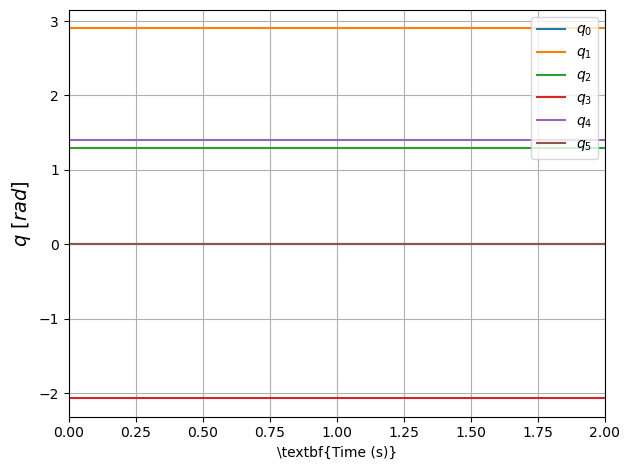

In [10]:
graphs_qs(t_list, q_list)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


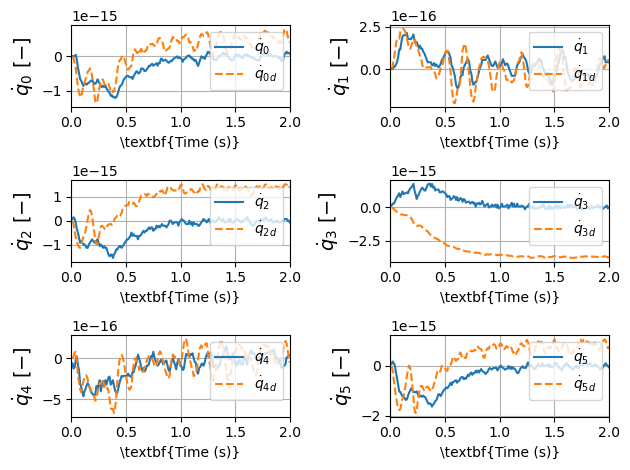

In [40]:
graphs_qdots(t_list, qdot_list, qdot_des_list)

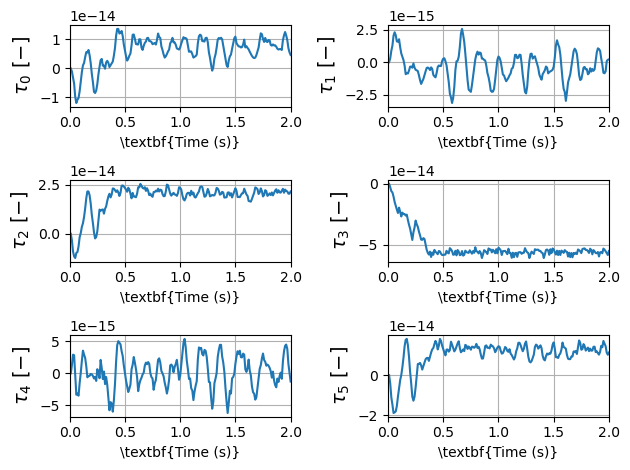

In [29]:
graphs_taus(t_list, u_list)

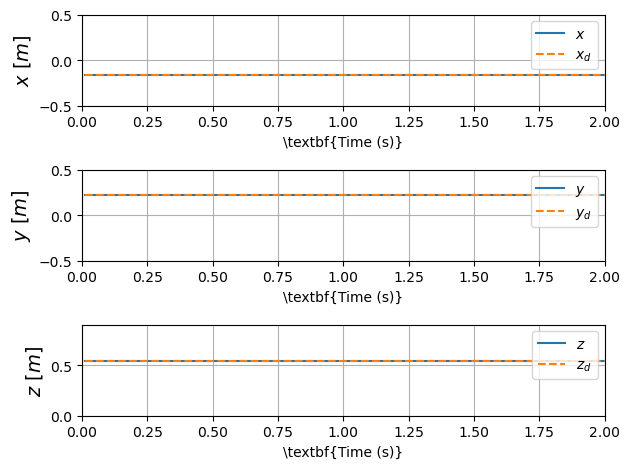

<Figure size 640x480 with 0 Axes>

In [32]:
graphs_pose(t_list, pose_list, pose_des_list)

In [51]:
from numpy import real, imag, linspace, exp, cos, sin, sqrt
from math import pi
def pzmap(poles,zeros):
    def _final_setup(ax):
        ax.set_xlabel('Real')
        ax.set_ylabel('Imaginary')
        ax.axhline(y=0, color='black', lw=1)
        ax.axvline(x=0, color='black', lw=1)
        plt.axis('equal')

    def zgrid(zetas=None, wns=None, ax=None):
        '''Draws discrete damping and frequency grid'''

        fig = plt.gcf()
        if ax is None:
            ax = fig.gca()

        # Constant damping lines
        if zetas is None:
            zetas = linspace(0, 0.9, 10)
        for zeta in zetas:
            # Calculate in polar coordinates
            factor = zeta/sqrt(1-zeta**2)
            x = linspace(0, sqrt(1-zeta**2), 200)
            ang = pi*x
            mag = exp(-pi*factor*x)
            # Draw upper part in retangular coordinates
            xret = mag*cos(ang)
            yret = mag*sin(ang)
            ax.plot(xret, yret, ':', color='grey', lw=0.75)
            # Draw lower part in retangular coordinates
            xret = mag*cos(-ang)
            yret = mag*sin(-ang)
            ax.plot(xret, yret, ':', color='grey', lw=0.75)
            # Annotation
            an_i = int(len(xret)/2.5)
            an_x = xret[an_i]
            an_y = yret[an_i]
            ax.annotate(str(round(zeta, 2)), xy=(an_x, an_y),
                        xytext=(an_x, an_y), size=7)

        # Constant natural frequency lines
        if wns is None:
            wns = linspace(0, 1, 10)
        for a in wns:
            # Calculate in polar coordinates
            x = linspace(-pi/2, pi/2, 200)
            ang = pi*a*sin(x)
            mag = exp(-pi*a*cos(x))
            # Draw in retangular coordinates
            xret = mag*cos(ang)
            yret = mag*sin(ang)
            ax.plot(xret, yret, ':', color='grey', lw=0.75)
            # Annotation
            an_i = -1
            an_x = xret[an_i]
            an_y = yret[an_i]
            num = '{:1.1f}'.format(a)
            ax.annotate(r"$\frac{"+num+r"\pi}{T}$", xy=(an_x, an_y),
                        xytext=(an_x, an_y), size=9)

        _final_setup(ax)
        return ax, fig

    ax, fig = zgrid()
    # Plot the locations of the poles and zeros
    if len(poles) > 0:
        ax.scatter(real(poles), imag(poles), s=25, marker='x',
                   facecolors='r')
    if len(zeros) > 0:
        ax.scatter(real(zeros), imag(zeros), s=25, marker='o',
                   facecolors='b', edgecolors='k')
    #plt.savefig('PolesZeros.eps', format='eps')
    plt.title('Pole Zero Map')    

In [53]:
qn = np.array([0, 2.9, 1.3, -2.07, 1.4,0]) # Natural position as in the real case
qdot = pin.utils.zero(model.nv) # this is the angular velocity
a = pin.utils.zero(model.nv) # angular acceleration

pin.forwardKinematics(model,data,qn)
pin.updateFramePlacements(model,data) #Computes the placement of all the joints
oMdes = data.oMf[model.getFrameId("j2s6s200_end_effector")] # I took the desired pose as the actual one

pin.computeJointJacobians(model, data, qn)
J= pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED)
J_inv = np.linalg.pinv(J)
dJ = pin.computeJointJacobiansTimeVariation(model,data,qn,qdot)

ts=0.01


d1 =1000; d2 =1000;  d3 =1000; d4 =0.85; d5 =0.85;  d6 =0.85
ds = np.array([d1, d2, d3])
Dd = np.diag(ds) #  Damper Matrix


md1 =ts*d1; md2 =ts*d2;  md3 =ts*d3; md4 =0.21; md5 =0.21;  md6 =0.21
mds = np.array([md1, md2, md3])
Md = np.diag(mds) # Mass Matrix
Md_inv = np.linalg.pinv(Md)

Jl = J[:3]
dJl = dJ[:3]
J_inv = np.linalg.pinv(Jl)
PI = J_inv@Md_inv@Dd@Jl
PHI = J_inv@Md_inv
GAMMA = J_inv@Md_inv@dJl
Ad = 0.9737
Bd = 0.0263
Cd = 1
I = np.identity(6)
o = (6,3)
oo= (6,6)
O = np.zeros(o)
OO = np.zeros(oo)


Ak_11 = I*Ad
Ak_12 = I*Bd
Ak_21 = -ts*I@PI
Ak_22 = (I-ts*GAMMA)
Ak_1 = np.concatenate((Ak_11,Ak_12),axis=1)
Ak_2 = np.concatenate((Ak_21,Ak_22),axis=1)
Ak = np.concatenate((Ak_1,Ak_2),axis=0)
Bk = np.concatenate((O,ts*PHI),axis=0)
Ck = np.concatenate((OO,I),axis=1)
Dk = O
sys_k =ct.ss(Ak,Bk,Ck,Dk)
P= ct.pole(sys_k);
Z= ct.zero(sys_k);

# for i in range(len(P)):
#     if(P[i]== np.isreal(P[i])):
#         P[i]= P[i]
#     else:
#         P[i]= np.linalg.norm(P[i])


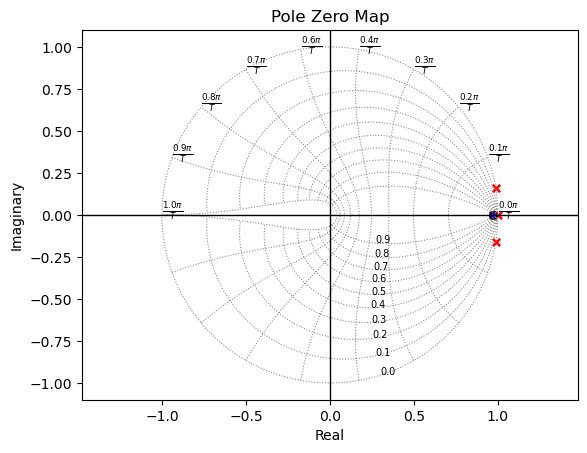

In [50]:
pzmap(P,Z)
plt.show()